***Méthodes numériques: Module 2***
***********************************
Space and Time: Modélisation de l'écoulement du trafic.
==
## Introduction #

Dans ce module nous allons résoudre une équation non-linéaire à deux variables en discrétisant à la fois dans le temps (en utilisant la forward-difference) et dans l'espace (en utilisant la backward-difference). Nous utiliserons également les nouveaux outils introduit dans ce module: sympy et lambdify, qui nous permettrons d'écrire des formules mathématiques dans nos codes et d'utiliser des fonctioncs de manière plus confortable. Nous importons donc comme dans le module 1 la librairie numpy et matplotlib pour pouvoir dessiner des graphiques mais également sympy et lambdify.

In [53]:
import numpy
import sympy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16
from sympy import init_printing
init_printing()
from sympy.utilities.lambdify import lambdify

## Principe #

L'équation que l'on se propose de résoudre est la suivante: $$\frac{\partial{\rho}}{\partial{t}}+\frac{\partial{F}}{\partial{\rho}}\frac{\partial{\rho}}{\partial{x}}=0$$ 

Cette équation modélise le flux du trafic de voitures sur l'autoroute. Il s'agit en fait de l'équation non-linéaire de convection appliquée à la densité de voiture, $\rho$. La fonction F représente le flux des voitures donné par $F=V \rho$ où V est la vitesse moyenne des voitures.

On modélise le fait que la vitesse varie en fonction de la densité de voiture en exprimant que la vitesse est maximale quand la densité de voiture est nulle et qu'elle est nulle quand la densité de voiture atteind une densité critique que l'on appelle $\rho_{max}$, ce qui se traduit par la formule suivante: 

$$V = V_{max}(1-\frac{\rho}{\rho_{max}})$$

Ainsi, on peut calculer que 
$$\frac{\partial{F}}{\partial{\rho}}=\frac{\partial{V \rho}}{\partial{\rho}} = V + \rho \frac{\partial{V}}{\partial{\rho}}$$

avec $$\frac{\partial{V}}{\partial{\rho}}=-\frac{V_{max}}{\rho_{max}}$$

On obtient finalement que $$\frac{\partial{F}}{\partial{\rho}}=V_{max} - 2\rho \frac{V_{max}}{\rho_{max}}$$
C'est-à-dire que l'équation que nous devons résoudre pour $\rho$ est $$\frac{\partial{\rho}}{\partial{t}}+(c_{1}\rho + c_{2})\frac{\partial{\rho}}{\partial{x}}=0$$ où $$c_{1}=-2\frac{V_{max}}{\rho_{max}}$$ et $$c_{2}=V_{max}$$

Il s'agit en fait d'une combinaison des deux exemples du Module 2. Maintenant que nous avons notre équation, nous pouvons la discrétiser. 
Les exposants représentent les indices de temps et les indices en dessous sont les indices pour l'espace. La discrétisation en avant pour le temps et en arrière pour l'espace nous donne l'équation suivante:
$$\frac{\rho_{i}^{n+1} - \rho_{i}^{n}}{\Delta t} + (c_{1}\rho_{i}^{n} + c_{2})(\frac{\rho_{i}^{n} - \rho_{i}^{n-1}}{\Delta x})=0$$

Dans cette équation, la seule inconnue à chaque itération est $\rho_{i}^{n+1}$. 

- On définit les paramètres du problème avec nt arbitraire :

In [54]:
vm=80.
L=11
rhom=250.
nx=51
nt=42
dx=L/(nx-1)
dt=.001

- On crée une fonction correspondant à F :

In [55]:
rho=sympy.symbols('rho')
V_max=sympy.symbols('V_max')
rho_max=sympy.symbols('rho_max')
F=rho*V_max*(1-rho/rho_max)

flamb=lambdify((rho,V_max,rho_max),F)

F


- On crée la fonction correspondant à la dérivée de F par rapport à rho :

In [56]:
fprim=F.diff(rho)

fprim_lamb=lambdify((rho,V_max,rho_max),fprim)

fprim

( Remarquons que la formule ci-dessus est bien égale à : $V_{max} - 2\rho \frac{V_{max}}{\rho_{max}} = \frac{\partial{F}}{\partial{\rho}}$ )

- On pose les conditions initiales pour la densité du traffic (voir Simulation Results : Part A) :

In [57]:
x = numpy.linspace(0,L,nx)
rho0 = numpy.ones(nx)*10
rho0[10:20] = 50

- Voyons l'allure de cette densité répartie sur la portion de route :

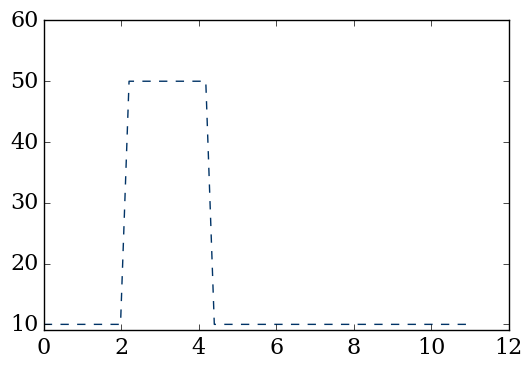

In [58]:
pyplot.plot(x, rho0, color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);

- À l'aide de notre fonction $\frac{\partial{F}}{\partial{\rho}}$ et de$$\frac{\rho_{i}^{n+1} - \rho_{i}^{n}}{\Delta t} + (c_{1}\rho_{i}^{n} + c_{2})(\frac{\rho_{i}^{n} - \rho_{i}^{n-1}}{\Delta x})=0$$ équivalent à : $$\rho_{i}^{n+1}=\rho_{i}^{n}-\frac{\Delta t}{\Delta x}(\rho_{i}^{n} - \rho_{i}^{n-1})\frac{\partial{F}}{\partial{\rho}}_{(\rho = \rho_{i}^{n})}$$

, nous trouvons la densité en fonction à un instant t définit par la valeur de nt choisie :

In [59]:
for n in range(1,nt):  
    rho = rho0.copy() 
    rho0[1:] = rho[1:]-fprim_lamb(rho[1:],vm,rhom)*dt/dx*(rho[1:]-rho[0:-1])
    rho0[0] = 10.

- Voyons maintenant l'allure de cette densité de traffic répartie sur la portion de route :

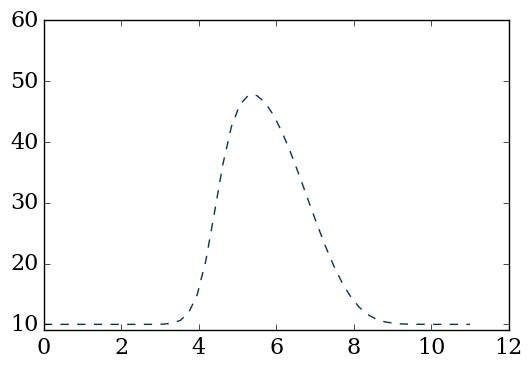

In [60]:
pyplot.plot(x, rho0, color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);

- Définissons, à l'aide de notre fonction F, le flot de traffic correspondant à la densité du traffic :

In [61]:
flist=numpy.zeros(nx)

for j in range(0,nx):
    flist[j]=flamb(rho0[j],vm,rhom)

- Voici l'allure du flot de traffic sur la portion de route :

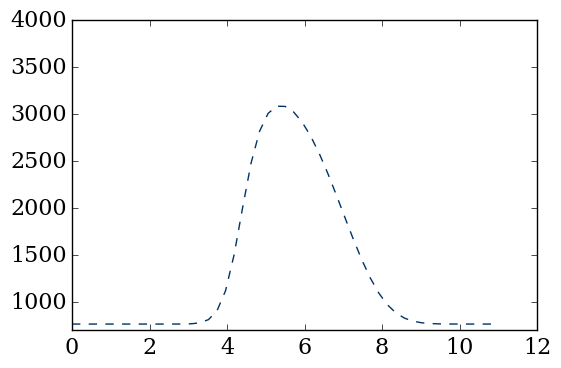

In [62]:
pyplot.plot(x, flist, color='#003366', ls='--', lw=1)
pyplot.ylim(700.,4000);

- On peut maintenant trouver la vitesse sur la portion de route à un certain instant grâce à la densité et à la formule : $V = V_{max}(1-\frac{\rho}{\rho_{max}})$

In [65]:
v=numpy.zeros(nx)
for i in range(0,nx):
    v[i]=vm*(1-rho0[i]/rhom)/3.6 # divion 3.6 pour la conversion aux unités SI
print (v)
print ('')
print ('(en m/s)')

[ 21.33333333  21.33333333  21.33333333  21.33333333  21.33333333
  21.33333333  21.33333333  21.33333333  21.33333333  21.33333333
  21.33333296  21.3333249   21.33323965  21.3326476   21.32960662
  21.31727041  21.27616679  21.16161606  20.89644937  20.40483038
  19.71260173  18.99642957  18.4447366   18.11883055  17.98368535
  17.98786526  18.09557609  18.28439466  18.53700791  18.83687091
  19.16728213  19.51167633  19.85402486  20.17921429  20.47365262
  20.72631678  20.93015841  21.08335938  21.18965864  21.25722531
  21.29634145  21.31689015  21.32666519  21.33087143  21.33250747
  21.33308218  21.33326428  21.33331622  21.33332953  21.33333258
  21.3333332 ]

(en m/s)


- Voici le graphique de la vitesse (à un instant correspondant à la valeur de nt choisie) sur la portion de route :

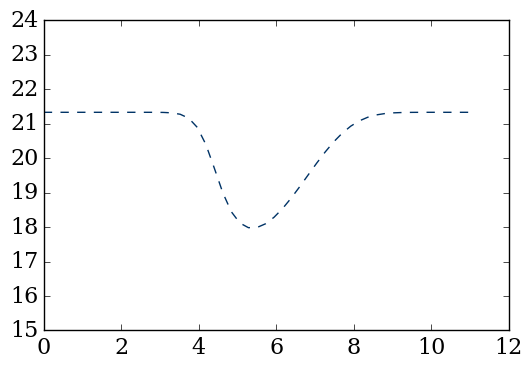

In [66]:
pyplot.plot(x, v, color='#003366', ls='--', lw=1)
pyplot.ylim(15.,24.);